
## NIX Data reduction

In [1]:
from erispy import get_file_list
from erispy.nix.data import get_science_data, get_calib_data, get_offset_rows, save_to_fits, get_bpm
from erispy.nix.plots import plot_file_frame, plot_data_with_zoomin, plot_in_axis
from erispy.nix.calib import create_master_sky, simple_calibration, correct_offset
from erispy.nix.stack import measure_sharpness

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import astroalign as aa
import pickle 

In [2]:
#Get data files
object_frames = get_file_list('../organized_data/raw_data',category='SCIENCE',type='OBJECT')
sky_frames    = get_file_list('../organized_data/raw_data',category='SCIENCE',type='SKY')
master_dark   = '../processed_calibs/master_darks/DIT_0.50/master_dark.fits'
flat_hifreq	  = '../processed_calibs/flatlamps_SLOW_GR_UTR/master_flat_lamp_hifreq.fits'
flat_lofreq	  = '../processed_calibs/flatlamps_SLOW_GR_UTR/master_flat_lamp_lofreq.fits'
master_sky    = './sky_average.fits'
sky_flat      = './mastersky.fits'

#Create reduced data based on the sky frames
#create_master_sky(sky_frames,master_dark,flat_lofreq,output='sky_average.fits')

### Example Calibration

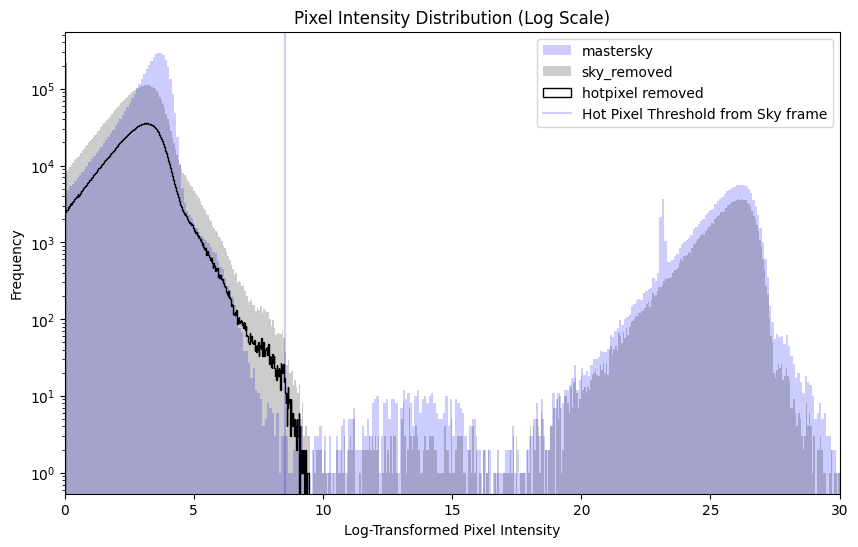

In [3]:
# Get all calibration files
light_frame = get_science_data(object_frames[24])[16]
mdark_frame = get_calib_data(master_dark)
hflat 		= get_calib_data(flat_hifreq)[:-2,:]
lflat 		= get_calib_data(flat_lofreq)[:-2,:]
msky 		= get_science_data(master_sky)
skyflat		= get_science_data(sky_flat)
bpm			= (get_bpm(master_dark) != 0)

#Correct the flat frame to include ones where there is nans
lflat = np.where( np.abs(lflat)<1e-2, 1, lflat)

#Subtract dark
image = light_frame-mdark_frame

#Correct detector stripes
image_calibrated, correction = correct_offset(image,nrows=-1,percentile=50)

#Divide by the flat sky
image_flatfielded = image_calibrated/lflat

#Subtract sky
image_sky_removed = image_flatfielded-msky

#Mask bad pixels with zero value
image_sky_removed[bpm==1] = 0.0

#Correct hot pixels based on the mastersky frame.
# Set the threshold according to the histogram below
threshold = 5e3

image_clean = np.copy(image_sky_removed)
image_clean[np.abs(msky) > threshold] = 0.0

#
# Look at histogram
#

calibrated_pixels = np.log1p(np.abs(image_calibrated.flatten()))
master_sky_pixels = np.log1p(np.abs(msky.flatten()))
image_sky_removed_pixels = np.log1p(np.abs(image_sky_removed.flatten()))
clean_pixels = np.log1p(np.abs(image_clean.flatten()))

# Plot the histogram of log-transformed values
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(master_sky_pixels, bins=500, color='blue', alpha=0.2, label='mastersky')
ax.hist(image_sky_removed_pixels, bins=500, color='black', alpha=0.2,label='sky_removed')
ax.hist(clean_pixels, bins=500, alpha=1,histtype='step', edgecolor='black',label='hotpixel removed')
ax.axvline(np.log1p(threshold), color='blue', linestyle='-', label='Hot Pixel Threshold from Sky frame',alpha=0.2)
ax.set_xlabel('Log-Transformed Pixel Intensity')
ax.set_ylabel('Frequency')
ax.set_title('Pixel Intensity Distribution (Log Scale)')
ax.set_xlim(0,30)
ax.set_yscale('log')
ax.legend()
plt.show()

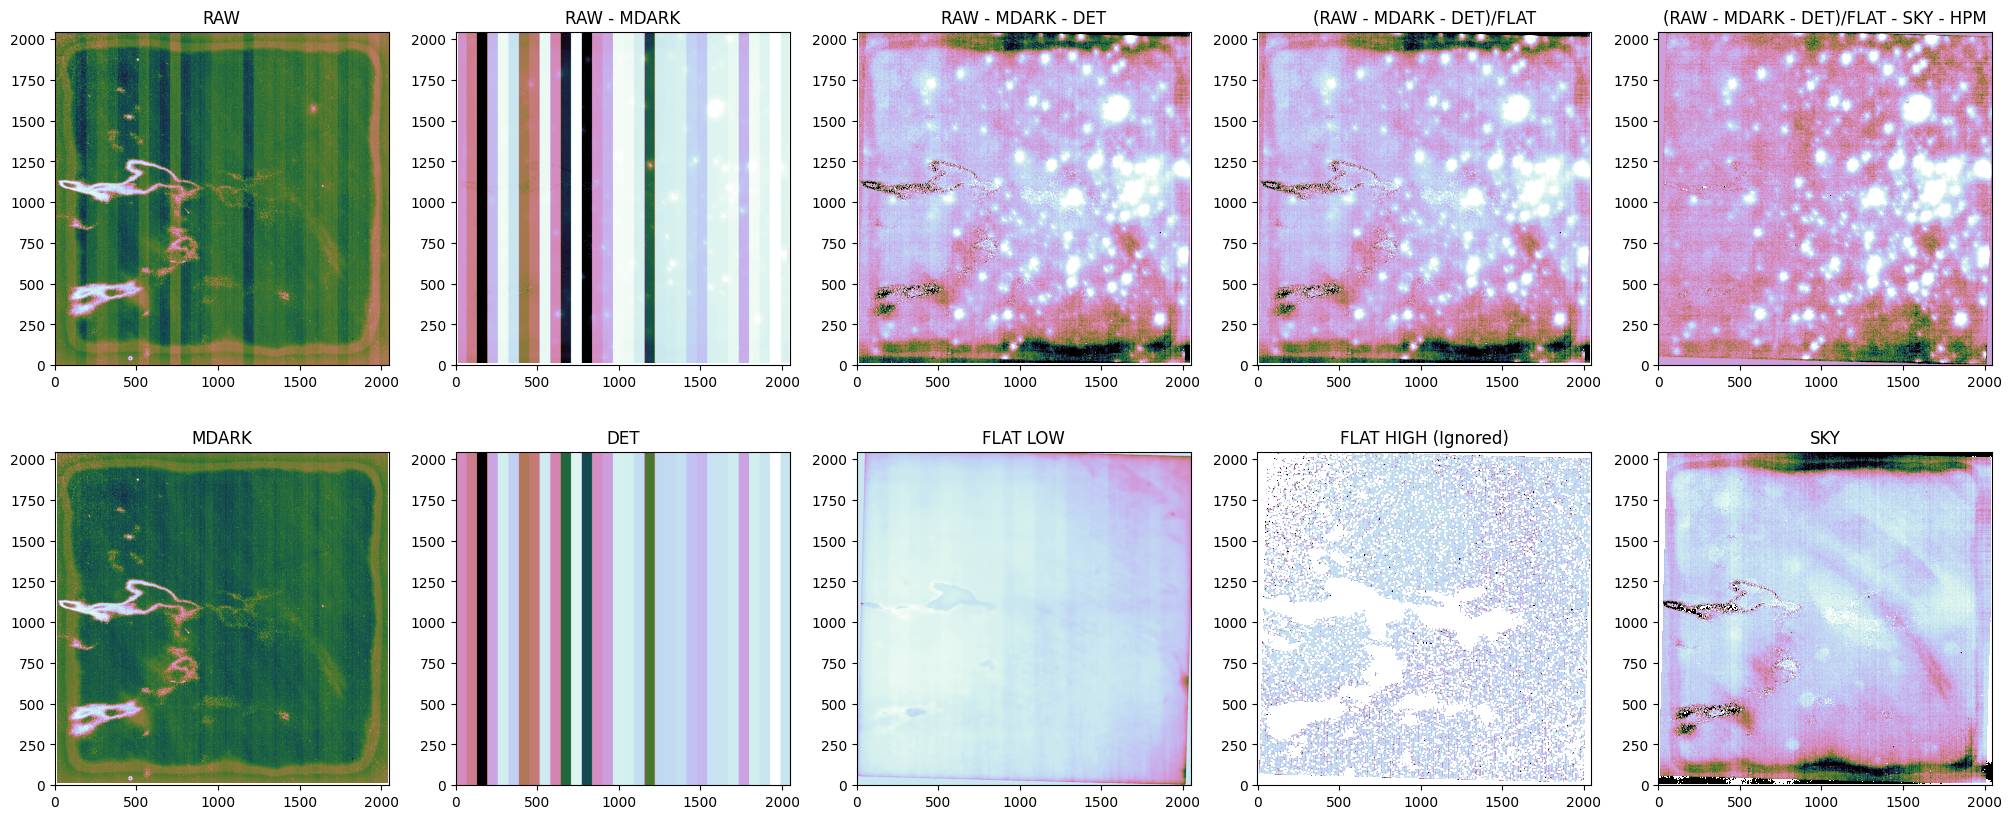

In [4]:
fig, axes = plt.subplots(figsize=(25,10), ncols=5,nrows=2)
ax1a,ax2a,ax3a,ax4a,ax5a = axes[0,:]
ax1b,ax2b,ax3b,ax4b,ax5b = axes[1,:]

ax1a.set_title('RAW')
ax2a.set_title('RAW - MDARK')
ax3a.set_title('RAW - MDARK - DET')
ax4a.set_title('(RAW - MDARK - DET)/FLAT')
ax5a.set_title('(RAW - MDARK - DET)/FLAT - SKY - HPM')

ax1b.set_title('MDARK')
ax2b.set_title('DET')
ax3b.set_title('FLAT LOW')
ax4b.set_title('FLAT HIGH (Ignored)')
ax5b.set_title('SKY')

#Science data
plot_in_axis(ax1a,light_frame)
plot_in_axis(ax2a,image,percentile=90)
plot_in_axis(ax3a,image_calibrated, percentile=90)
plot_in_axis(ax4a,image_flatfielded, percentile=90)
plot_in_axis(ax5a,image_clean, percentile=90)

#Calibration data
plot_in_axis(ax1b,mdark_frame)
plot_in_axis(ax2b,correction)
plot_in_axis(ax3b,lflat,percentile=99.99)
plot_in_axis(ax4b,hflat,percentile=90)
plot_in_axis(ax5b,msky,percentile=90)

In [5]:
output_data = image_clean
save_to_fits(output_data,'test.fits')

### Calibrate all files

In [ ]:
for frame in object_frames:
	simple_calibration(frame, masterdark=master_dark,masterflat=flat_lofreq,mastersky=master_sky)

### Sharpness and alignment

In [6]:
#Fetch science calibrated files
from glob import glob
fits_files = glob('./ERIS*.fits')

In [7]:
#Plot one frame from each file to chose a reference frame to which you'll align the remaining frames
for file in fits_files:
	plot_file_frame(file,percentile=99.5,cmap='cubehelix')

In [7]:
#Chose a file that you think is the best one as the basis of all alignments (check the best frame using QFits view)
ref_file = './ERIS.2024-08-19T04:16:06.753_simple_calib.fits'
ref_frame = 13-1
ref_image = get_science_data(ref_file)[ref_frame]

In [ ]:

# These are the coordinates of a isolated enough star that can be used to acess the sharpness of each frame
x0, y0 = 1236,1171
fig, axes = plot_data_with_zoomin(ref_image, x0=x0, y0=y0, w=60,percentile=99.9,cmap='gray')

axes[0].scatter(x0,y0,s=0.2)
axes[1].scatter(x0,y0)
#Measure the sharpness of this image
print(measure_sharpness(ref_image, star_position=(x0,y0), crop_size=60))

In [ ]:
#Get reference frame
ref_file = './ERIS.2024-08-19T04:16:06.753_simple_calib.fits'
ref_frame = 13-1
ref_image = get_science_data(ref_file)[ref_frame]
x0, y0 = 1236,1171

#Evaluate the sharpness and alignment of each frame
sharpness_list = {file: np.zeros(60) for file in fits_files}
threshold = 2.5

for idx,file in enumerate(sharpness_list):
	
	print( 'file', idx,'of', len(sharpness_list), '| Evaluating file: ', file)

	#Get data for each file
	data = get_science_data(file)

	for idx in tqdm(range(len(data)), desc="Processing"):

		#print(np.shape(data[idx].astype(np.float32)))	
		#Align image
		try:
			img_aligned, footprint = aa.register(
	 			source=data[idx].astype(np.float32), 
				target=ref_image.astype(np.float32), 
				detection_sigma=5)
			
			#s = measure_sharpness(img_aligned, star_position=(x0,y0), crop_size=60)
			sharpness_list[file][idx] = measure_sharpness(img_aligned, star_position=(x0,y0), crop_size=60)
	
		except Exception as e:
			print('Error: {}'.format(e))	
	
#Save dictionary
with open('sharpness.pkl', 'wb') as f:
    pickle.dump(sharpness_list, f)


### Evaluate sharpness distribution and stack desired frames

In [ ]:
#Load dictionary
with open('saved_dictionary.pkl', 'rb') as f:
	sharp_list = pickle.load(f)     

#Create list with all sharpness measures  
sharpness_distribuition = []
for key in sharp_list:
	sharpness_distribuition.append( sharp_list[key])

sharpness_distribuition = np.asarray(sharpness_distribuition)

#Clean negative and infinite sharpness values
sharpness_distribuition = sharpness_distribuition[sharpness_distribuition!=np.inf]
sharpness_distribuition = sharpness_distribuition[sharpness_distribuition>0]

#Evaluate threshold frames
lthreshold = 1.9
hthreshold = 3.5
selected_frames = sharpness_distribuition[(sharpness_distribuition>lthreshold) & (sharpness_distribuition<hthreshold)]

print('Total number of frames stacked: ', len(sharpness_distribuition))
print('Total number of frames below threshold: ', len(selected_frames))

In [ ]:
fig,ax = plt.subplots(figsize=(10,5))
ax.hist(sharpness_distribuition,bins=100)
ax.hist(selected_frames,bins=20)
plt.show()

In [ ]:
#Find frames to stack
ref_file = './ERIS.2024-08-19T04:16:06.753_simple_calib.fits'
ref_frame = 13-1
ref_image = get_science_data(ref_file)[ref_frame]

result =np.zeros_like(ref_image)
nf = 0
nftot = len(selected_frames)
for key in sharp_list:
    
	sharp_values = sharp_list[key]

	for idx,sharp in enumerate(sharp_values):
		if (1.9 < sharp < 3.5) and sharp != np.inf:
			try:
				unaligned_data = get_science_data(key)[idx]
				img_aligned, _ = aa.register(
	 				source=unaligned_data.astype(np.float32), 
					target=ref_image.astype(np.float32), 
					detection_sigma=5)
				result += img_aligned
				nf+=1
				print('frame',nf, '/', nftot)
			except:
				pass

In [ ]:
x0, y0 = 1236,1171
fig, axes = plot_data_with_zoomin(result, x0=x0, y0=y0, w=60,percentile=99.9,cmap='gray')

In [46]:
save_to_fits(result,fname='./aligned_test_3.5.fits')

### Estimate PSF

In [109]:
import numpy as np
import matplotlib.pyplot as plt

from erispy.nix.data import get_science_data
from erispy.nix.plotting import plot_data_with_zoomin
from erispy.nix.data import save_to_fits

from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clipped_stats
from scipy.spatial import KDTree

from astropy.nddata import Cutout2D
from astropy.visualization import simple_norm


def plot_isolated_stars(isolated_stars,image_data,cutout_size):

	# Parameters for grid
	n_stars = len(isolated_stars)    # Number of isolated stars
	n_cols = 15                        # Number of columns in the grid
	n_rows = int(np.ceil(n_stars / n_cols))  # Calculate required rows

	fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows*1.2))
	axes = axes.flatten()  # Flatten to easily index each subplot

	# Loop through the stars and create cutouts for each
	for i, star in enumerate(isolated_stars):
		position = (star['xcentroid'], star['ycentroid'])
		cutout = Cutout2D(image_data, position, size=(cutout_size, cutout_size))
		
		# Plot cutout in the i-th grid cell
		norm = simple_norm(cutout.data, 'log', percent=99.0)
		axes[i].imshow(cutout.data, origin='lower', cmap='gray',norm=norm)
		axes[i].set_title(f'Star {i}', fontsize=8)
		axes[i].axis('off')  # Turn off axes for cleaner look

	# Hide any empty subplots if the grid has extra slots
	for j in range(i, len(axes)):
		axes[j].axis('off')

	return fig, axes


#### Find Isolated stars

In [ ]:
#Get data
image_data = get_science_data('./aligned_test_3.5.fits')/309
height, width = image_data.shape  

#Minimum pixel distance between stars and the 'reference star' used before for sharpness measurement
min_distance  = 11
cutout_region = 55 
x0, y0 = 1236,1171
#Find stars in the image
mean, median, std = sigma_clipped_stats(image_data, sigma=3.0)
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)
sources = daofind(image_data - median)
coords = np.transpose((sources['xcentroid'], sources['ycentroid']))
tree = KDTree(coords)

#Ignore stars that are too close to the edge
isolated_stars = []
for i, coord in enumerate(coords):
	
	x, y = coord
	distance_to_left_edge = x
	distance_to_right_edge = width - x
	distance_to_top_edge = y
	distance_to_bottom_edge = height - y
	
	min_distance_to_edge = min(distance_to_left_edge, distance_to_right_edge, distance_to_top_edge, distance_to_bottom_edge)
    
	distances, indices = tree.query(coord, k=2)  
	if (distances[1] > min_distance) and (min_distance_to_edge > min_distance):  
		isolated_stars.append(sources[i])
		
print('Found ', len(isolated_stars), 'stars')

#Display stars
fig, axes = plot_data_with_zoomin(image_data, x0=x0, y0=y0, w=120,percentile=99.9,cmap='gray')

for star in isolated_stars:
	axes[0].scatter(star['xcentroid'],star['ycentroid'],s=0.2,c='blue')

In [ ]:
fig, axes = plot_isolated_stars(isolated_stars,image_data,cutout_size=cutout_region)

#Stars to drop (option 1)
#indexes_to_drop = [0,2,9,10,12,13,14,16,18,20,21,22,23,24,25,28,29,33,34,35,36,37,38,39,40,42,43,44,45,46,47,48,49,50,51,52,53,54,57,58,59,60,62,65,66,68,69,70,72,73,74]#4,6,7,8,9,12,14,15,16,17,18,20,21,22,23,24,25,28,29,30,31,32,33,34,36]
#filtered_stars = [star for i, star in enumerate(isolated_stars) if i not in indexes_to_drop]

#Stars to keep (option 2)
indexes_to_keep = [1,4,6,7,8,13,15,16,20,22,48,57,61,174,264,291]
filtered_stars = [star for i, star in enumerate(isolated_stars) if i in indexes_to_keep]

fig, axes = plot_isolated_stars(filtered_stars,image_data,cutout_size=cutout_region)

#### Method 1: Stack stars

In [ ]:
from scipy.ndimage import gaussian_filter

# Define cutout size for each star
cutout_size = int(cutout_region)
cutouts = []

list_of_stars=filtered_stars

#Get stars but skip if the cutout is too close to the edge
for idx,star in enumerate(list_of_stars):
	position = (star['xcentroid'], star['ycentroid'])  # (y, x) for Cutout2D
	cutout = Cutout2D(image_data, position, size=cutout_size)
	
	if cutout.data.shape == (cutout_size, cutout_size):
		cutouts.append(cutout.data)
	else:
		print(f"Cutout at {coord} has shape {cutout.data.shape} and is being skipped.")

cutout_stack = np.array(cutouts)


# Normalize cutouts (optional)
normalized_cutouts = cutout_stack / np.max(cutout_stack, axis=(1, 2), keepdims=True)

# Average the normalized cutouts to estimate the PSF
psf_estimate = np.mean(normalized_cutouts, axis=0)

# Optionally, smooth the PSF estimate (Gaussian smoothing)
psf_estimate_smoothed = gaussian_filter(psf_estimate, sigma=3)


plt.subplot(1, 2, 1)
norm = simple_norm(psf_estimate, 'log', percent=99.0)
plt.imshow(psf_estimate, origin='lower', cmap='gray',norm=norm)
plt.title('Estimated PSF')

plt.subplot(1, 2, 2)
plt.imshow(psf_estimate_smoothed, origin='lower', cmap='gray',norm=norm)
plt.title('Smoothed PSF')

plt.show()

#### Method 2: Fit Airy profile to stacked stars and create mock PSF

In [ ]:
import numpy as np
import scipy.optimize as opt
import scipy.special as sp
import matplotlib.pyplot as plt

# Define the Airy Disk function in 2D
def airy_disk(x, y, x0, y0, I0, k):
    r = np.sqrt((x - x0)**2 + (y - y0)**2)
    # Prevent division by zero by replacing zero distance with a small value
    r[r == 0] = 1e-10
    return I0 * (2 * sp.j1(k * r) / (k * r))**2

# Generate mesh grid coordinates
def create_mesh(data):
    y = np.arange(data.shape[0])
    x = np.arange(data.shape[1])
    X, Y = np.meshgrid(x, y)
    return X, Y

# Fit the Airy Disk to data
def fit_airy(data):
    X, Y = create_mesh(data)
    # Flatten the arrays for fitting
    x_data = X.ravel()
    y_data = Y.ravel()
    z_data = data.ravel()
    
    # Initial guess for the parameters: (x0, y0, I0, k)
    initial_guess = (X.shape[1] // 2, Y.shape[0] // 2, data.max(), 1.5)
    
    # Fit the data using least squares
    popt, pcov = opt.curve_fit(lambda xy, x0, y0, I0, k: airy_disk(xy[0], xy[1], x0, y0, I0, k).ravel(),
                               (x_data, y_data), z_data, p0=initial_guess)
    
    # Extract fitted parameters
    x0_fit, y0_fit, I0_fit, k_fit = popt
    print("Fitted parameters: x0 =", x0_fit, "y0 =", y0_fit, "I0 =", I0_fit, "k =", k_fit)
    
    return x0_fit, y0_fit, I0_fit, k_fit

# Generate a mock PSF using fitted parameters
def generate_mock_psf(shape, x0, y0, I0, k):
    X, Y = create_mesh(np.zeros(shape))
    return airy_disk(X, Y, x0, y0, I0, k)

# Example usage
# Load or define your 2D PSF data here
data = psf_estimate#np.random.rand(100, 100)  # Replace with actual PSF data

# Fit the data
x0_fit, y0_fit, I0_fit, k_fit = fit_airy(data)

# Generate the mock PSF
mock_psf = generate_mock_psf(data.shape, x0_fit, y0_fit, I0_fit, k_fit)

# Plot original data and mock PSF
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original PSF Data")
norm = simple_norm(data, 'log', percent=99.9)
plt.imshow(data, cmap='viridis',norm=norm)
#plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Fitted Airy Profile (Mock PSF)")
plt.imshow(mock_psf, cmap='viridis',norm=norm)
#plt.imshow(data-mock_psf, cmap='viridis',norm=norm)
#plt.colorbar()
plt.show()


#### Method 3: Iterative method with photutils

In [ ]:
from astropy.table import Table

#Get data as a Table
xdata = np.zeros(len(filtered_stars))
ydata = np.zeros(len(filtered_stars))

for idx,star in enumerate(filtered_stars):
	xdata[idx] = star['xcentroid']
	ydata[idx] = star['ycentroid']

stars_tbl = Table()
stars_tbl['x'] = xdata  
stars_tbl['y'] = ydata 

from astropy.nddata import NDData
nddata = NDData(data=image_data) 

from photutils.psf import extract_stars
stars = extract_stars(nddata, stars_tbl, size=cutout_region) 

from photutils.psf import EPSFBuilder
epsf_builder = EPSFBuilder(oversampling=1, maxiters=100, progress_bar=True)  
epsf, fitted_stars = epsf_builder(stars)  


#### Deconvolve Image

In [166]:
from scipy.signal import convolve
from skimage.restoration import richardson_lucy

#Method 1: Stacking
psf=psf_estimate

#Method 2: Fitting stacked image
psf=mock_psf

#Method 2: photutils estimate
psf = epsf.data

#Normalize psf and make pixels all positive
psf /= np.sum(psf)
to_deconvolve = image_data - np.min(image_data)

#Deconvolve image with RL method or with simple deconvoluton
deconvolved_image = richardson_lucy(to_deconvolve, psf, num_iter=30,filter_epsilon=1e-11,clip=False)
#deconvolved_image = convolve(to_deconvolve, psf, mode='same')


In [ ]:
fig, axes = plot_data_with_zoomin(deconvolved_image, x0=x0, y0=y0, w=500,percentile=99.99,cmap='cubehelix')

In [173]:
save_to_fits(deconvolved_image,'./lucy_deconvolved_image.fits')

### Estimate GC asterism positions

In [ ]:
#Load image
data = get_science_data('./lucy_deconvolved_image.fits')

#Define a dictionary with the stars
pos_irs16sw = np.array([1326, 1279])

asterism = {
    'IRS16SW' : pos_irs16sw,
    'IRS16NW' : pos_irs16sw - (79,-164),
    'IRS16C'  : pos_irs16sw - (22,-119),
    'IRS16CC' : pos_irs16sw - (-57,-121),
    'IRS16NE' : pos_irs16sw - (-132,-131)
}

fig, axes = plot_data_with_zoomin(data, x0=1350, y0=1400, w=500,percentile=99.99,cmap='cubehelix')

for star in asterism:
    axes[0].scatter(asterism[star][0],asterism[star][1],c='blue')
    axes[1].scatter(asterism[star][0],asterism[star][1],c='blue')
    

In [ ]:
#Measure exact position of star
from scipy.optimize import curve_fit

# Define a 2D Gaussian function
def gaussian_2d(xy, A, x0, y0, sigma_x, sigma_y, C):
	x, y = xy
	return A * np.exp(-((x - x0)**2 / (2 * sigma_x**2) + (y - y0)**2 / (2 * sigma_y**2))) + C

# Function to fit a 2D Gaussian to the data
def fit_gaussian_2d(data, initial_guess):
	y_size, x_size = data.shape
	y = np.arange(y_size)
	x = np.arange(x_size)
	X, Y = np.meshgrid(x, y)
	
	# Flatten the arrays for fitting
	x_data = X.ravel()
	y_data = Y.ravel()
	z_data = data.ravel()
	
	# Unpack initial guess for (x0, y0)
	x0, y0 = initial_guess
	A_initial = data.max()    # Initial guess for amplitude
	sigma_x_initial = sigma_y_initial = 1.0  # Initial guess for width
	C_initial = np.median(data)  # Initial guess for background

	# Combine all initial guesses
	initial_params = (A_initial, x0, y0, sigma_x_initial, sigma_y_initial, C_initial)
	
	# Fit the data using curve_fit
	popt, pcov = curve_fit(gaussian_2d, (x_data, y_data), z_data, p0=initial_params)
	
	# Extract fitted parameters and their standard deviations (sqrt of diagonal elements)
	A_fit, x0_fit, y0_fit, sigma_x_fit, sigma_y_fit, C_fit = popt
	uncertainties = np.sqrt(np.diag(pcov))
	A_std, x0_std, y0_std, sigma_x_std, sigma_y_std, C_std = uncertainties

	print("Center (x0, y0) = ({}, {}) +/- ({}, {})".format(x0_fit, y0_fit, x0_std, y0_std))
	
	return popt, uncertainties 
	
#Create a copy of the function
asterism_fit = copy.deepcopy(asterism)

for star in asterism:   
	print('Fitting star:', star)
	fitted_params, uncertainty = fit_gaussian_2d(data, (asterism[star][0],asterism[star][1] ))
	asterism_fit[star] = np.concatenate((fitted_params[1:3], uncertainty[1:3]))

In [ ]:
from itertools import combinations
import numpy as np
import csv

def calculate_distances(star_data, scale_factor, print_results=False, save_to_csv=False, filename="distances.csv"):
    distances = {}
    
    # Generate all unique pairs of stars
    for (star1, data1), (star2, data2) in combinations(star_data.items(), 2):
        # Extract position and uncertainty data
        x1, y1, dx1, dxy1 = data1
        x2, y2, dx2, dxy2 = data2

        # Calculate the Euclidean distance in pixels
        distance_pixels = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        
        # Calculate the uncertainty in distance in pixels using error propagation
        d_distance_pixels = np.sqrt(((x2 - x1) * dx1)**2 + ((y2 - y1) * dxy1)**2 +
                                    ((x2 - x1) * dx2)**2 + ((y2 - y1) * dxy2)**2) / distance_pixels

        # Convert distance and uncertainty from pixels to milliarcseconds
        distance_mas = distance_pixels * scale_factor
        d_distance_mas = d_distance_pixels * scale_factor

        # Store result in dictionary with both scaled and unscaled values
        distances[(star1, star2)] = {
            "distance_pixels": distance_pixels,
            "uncertainty_pixels": d_distance_pixels,
            "distance_mas": distance_mas,
            "uncertainty_mas": d_distance_mas
        }
    
    # Optionally print results in a neat format
    if print_results:
        print(f"{'Star Pair':<15} {'Dist (pix)':<12} {'Uncert (pix)':<12} {'Dist (mas)':<12} {'Uncert (mas)':<12}")
        print("=" * 63)
        for (star1, star2), values in distances.items():
            print(f"{star1} - {star2:<10} {values['distance_pixels']:<12.4f} {values['uncertainty_pixels']:<12.4f} "
                  f"{values['distance_mas']:<12.4f} {values['uncertainty_mas']:<12.4f}")

    # Optionally save to CSV file
    if save_to_csv:
        with open(filename, mode='w', newline='') as file:
            writer = csv.writer(file)
            # Write header
            writer.writerow(["Star Pair", "Distance (pix)", "Uncertainty (pix)", "Distance (mas)", "Uncertainty (mas)"])
            # Write each row of data
            for (star1, star2), values in distances.items():
                writer.writerow([f"{star1} - {star2}",
                                 f"{values['distance_pixels']:.4f}",
                                 f"{values['uncertainty_pixels']:.4f}",
                                 f"{values['distance_mas']:.4f}",
                                 f"{values['uncertainty_mas']:.4f}"])
        print(f"Results saved to {filename}")

    return distances

distances = calculate_distances(asterism_fit, scale_factor=13,print_results=True,save_to_csv=True)
